<a href="https://colab.research.google.com/github/saylejl24/ImagePlay/blob/main/RANSAC_matching_Imgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stitching Images Together
Jenna Sayle
10/25/2022

### Read in images

In [ ]:
import cv2
import numpy as np
img1 = (cv2.imread("sample_data/campus_001.jpg",cv2.IMREAD_GRAYSCALE))

img2 = (cv2.imread("sample_data/campus_000.jpg",cv2.IMREAD_GRAYSCALE))

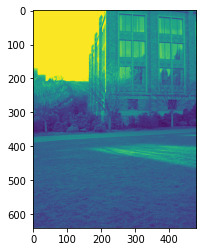

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img1)

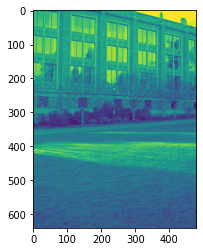

In [ ]:
plt.imshow(img2)

### Extract Features
search matched pairs of points

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow

In [ ]:
def ratioTest(matches, ratio = 0.7):
  good = []
  for m,n in matches:
    if m.distance < ratio * n.distance:
      good.append([m])
  return good

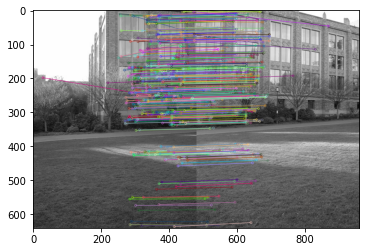

(<matplotlib.image.AxesImage at 0x7f0b0bd11450>, None)

In [ ]:

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

good = []

match_coords = []

for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        match_coords.append([kp1[m.queryIdx].pt, kp2[m.trainIdx].pt])

# Apply ratio test
good = ratioTest(matches)

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3),plt.show()

In [ ]:
def getPoints(matches, keyPsrc, keyPdst):
  src = []
  dst = []

  for m,n in matches:
    src_i = m.queryIdx
    dst_i = m.trainIdx

    (x1, y1) = keyPsrc[src_i].pt
    (x2, y2) = keyPdst[dst_i].pt

    src.append([x1, y1])
    dst.append([x2, y2])
  
  src = np.asarray(src)
  dst = np.asarray(dst)
  return src, dst

In [ ]:
srcpts, dstpts = getPoints(matches, kp1, kp2)
srcpts

array([[  2.3098526 , 181.96546936],
       [  2.88707399, 537.46942139],
       [  2.89177585, 540.30084229],
       ...,
       [476.39169312,  91.99315643],
       [476.46990967,  99.4634552 ],
       [477.01141357,  12.02552032]])

### SVD Algorithm
calculate H Matrix

In [ ]:
def calculateH(p1, p2):
  A = []
  for i in range(0, len(p1)):
    x,y = p1[i][0], p1[i][1]
    u,v = p2[i][0], p2[i][1]
    A.append([x, y, 1, 0, 0, 0, (-u * x), (-u * y), -u])
    A.append([0, 0, 0, x, y, 1, (-v * x), (-v * y), -v])
  A = np.asarray(A)
  U, S, Vh = np.linalg.svd(A)
  L = Vh[-1,:] / Vh[-1,-1]
  H = L.reshape(3,3)
  return H 

### RANSAC
calculated distance between estimated and actual point

In [ ]:
import random
import math

def RANSAC(s, N, d, T, m_x, m_y):
  
  inlierCount = 0 
  BestModel = None
  #inlierBest_1 = None
  in_1B = []
  #inlierBest_2 = None
  in_2B = []
  goodbest = []

  for i in range(0,N): # replace 3 with N 
    print("Iteration Number : ", i)
    
    pts1 = []
    pts2 = []
    
    # get random set of s = 4 matching points
    for j in range (0,s):
     indx = random.randint(0, len(m_x) - 1)
     pts1.append(m_x[indx])
     pts2.append(m_y[indx])
    #print(pts1)

    # compute H matrix for these pts using SSD 
    H_mat = calculateH(pts1, pts2)
    
    count = 0
    # Count inliers
    in_1 = []
    in_2 = []
    good = []

    for m in range(0,len(m_x)):
      pt1 = [m_x[m][0], m_x[m][1], 1]
      ptReal = [m_y[m][0], m_y[m][1], 1]
      predPt = H_mat.dot(pt1)

      matchPt = matches[m][0] # query, train , distance

      distance = math.sqrt( pow((ptReal[0] - predPt[0]) / predPt[2], 2)   + pow((ptReal[1] - predPt[1]) / predPt[2], 2) )
      
      if(abs(distance) < T):
        count+=1
        print(distance)
        in_1.append(pt1)
        in_2.append(ptReal)
        #good.append([pt1, ptReal])
        good.append([matchPt])

    print("Inlier Count : ", count)
    
    # Keep H if Largest number of inliers
    if(count > inlierCount):
      inlierCount = count 
      BestModel = calculateH(in_1, in_2)
      in_1B = in_1
      in_2B = in_2
      goodbest = good

  # recompute H using all inleirs 
  H_recomp = calculateH(in_1B, in_2B)
  #print(H_recomp)

  print("best Model  : ", BestModel, "Has Inleir Count :", inlierCount)
  return H_recomp, in_1B, in_2B, goodbest


In [ ]:
model, inliers_1, inliers_2, good2 = RANSAC(4, 5000, 1, .9 , srcpts, dstpts) #threshold = np.std(matches_2)/2 .5 .75

Streaming output truncated to the last 5000 lines.
Iteration Number :  2517
Inlier Count :  0
Iteration Number :  2518
Inlier Count :  0
Iteration Number :  2519
Inlier Count :  0
Iteration Number :  2520
Inlier Count :  0
Iteration Number :  2521
Inlier Count :  0
Iteration Number :  2522
Inlier Count :  0
Iteration Number :  2523
Inlier Count :  0
Iteration Number :  2524
Inlier Count :  0
Iteration Number :  2525
Inlier Count :  0
Iteration Number :  2526
Inlier Count :  0
Iteration Number :  2527
Inlier Count :  0
Iteration Number :  2528
Inlier Count :  0
Iteration Number :  2529
Inlier Count :  0
Iteration Number :  2530
Inlier Count :  0
Iteration Number :  2531
Inlier Count :  0
Iteration Number :  2532
Inlier Count :  0
Iteration Number :  2533
Inlier Count :  0
Iteration Number :  2534
Inlier Count :  0
Iteration Number :  2535
Inlier Count :  0
Iteration Number :  2536
Inlier Count :  0
Iteration Number :  2537
Inlier Count :  0
Iteration Number :  2538
Inlier Count :  0
Ite

In [ ]:
realH = cv.findHomography(np.array(srcpts), np.array(dstpts)) #, cv.RANSAC, 5.0
print("My Version: ", model)
print("CV version: ", realH[0])

My Version:  [[ 1.11056158e+00 -3.19852639e-02 -2.85415195e+02]
 [ 1.03202182e-01  1.09001971e+00 -4.51487973e+01]
 [ 2.31379390e-04 -5.79443296e-06  1.00000000e+00]]
CV version:  [[-2.54167772e-01 -6.63234800e-01  1.93626607e+02]
 [-3.43365210e-01 -8.92374844e-01  2.60992087e+02]
 [-1.31219880e-03 -3.42612751e-03  1.00000000e+00]]


In [ ]:
print(len(good2))
print(good)

62
[[< cv2.DMatch 0x7f0b0de70f70>], [< cv2.DMatch 0x7f0b0df86190>], [< cv2.DMatch 0x7f0b0df7e810>], [< cv2.DMatch 0x7f0b0df7ead0>], [< cv2.DMatch 0x7f0b0df7eb10>], [< cv2.DMatch 0x7f0b0df7ee90>], [< cv2.DMatch 0x7f0b0df770d0>], [< cv2.DMatch 0x7f0b0df77110>], [< cv2.DMatch 0x7f0b0df77710>], [< cv2.DMatch 0x7f0b0df77850>], [< cv2.DMatch 0x7f0b0df77890>], [< cv2.DMatch 0x7f0b0df778d0>], [< cv2.DMatch 0x7f0b0df77990>], [< cv2.DMatch 0x7f0b0df779d0>], [< cv2.DMatch 0x7f0b0df77a50>], [< cv2.DMatch 0x7f0b0df77a90>], [< cv2.DMatch 0x7f0b0df77b90>], [< cv2.DMatch 0x7f0b0df77bd0>], [< cv2.DMatch 0x7f0b0df77c50>], [< cv2.DMatch 0x7f0b0df77d50>], [< cv2.DMatch 0x7f0b0df77dd0>], [< cv2.DMatch 0x7f0b0df77e10>], [< cv2.DMatch 0x7f0b0df77e50>], [< cv2.DMatch 0x7f0b0df77e90>], [< cv2.DMatch 0x7f0b0df77ed0>], [< cv2.DMatch 0x7f0b0df77f10>], [< cv2.DMatch 0x7f0b0df77fd0>], [< cv2.DMatch 0x7f0b0df740d0>], [< cv2.DMatch 0x7f0b0df74110>], [< cv2.DMatch 0x7f0b0df74150>], [< cv2.DMatch 0x7f0b0df74190>], [< c

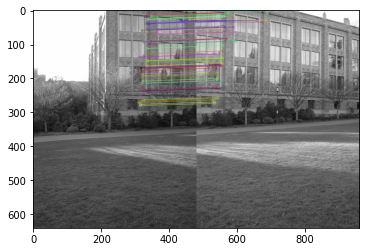

(<matplotlib.image.AxesImage at 0x7f0b0bb3f0d0>, None)

In [ ]:
# draw updated matches from H matrix 
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good2,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### Warping Algorithm 
forward, Backward (nearest neighbor algorithm), Backward (weighted average solution)

### Stitching multiple images 
[example](https://courses.cs.washington.edu/courses/csep576/20sp/projects/Project2.html)